# Lung Disease Diagnosis - Model Tuning

Developer: Tung Nguyen

This notebook is a continuation of model-tuning-1.ipynb and experiments with larger deep learning architectures for the [lung disease diagnosis dataset](https://www.kaggle.com/datasets/nih-chest-xrays/data).

The best performing models from model-tuning-1.ipynb were model-1 (baseline) and model-3 ('stratified' sampling - minority classes are sampled with replacement to combat class imbalance).

This notebook attempts to scale up and trains an Xception and DenseNet169 model, using learnings from the VGG16 studies.
<br>
<br>

__MODEL SUMMARY TABLE__
|  | 8 | 9 | 10 | 11 | 12 |
| --- | --- | --- | --- | --- | --- |
| Loss | BCE | BCE | BCE | BCE | Weighted BCE |
| Base Model | Xception | Xception | DenseNet169 | DenseNet169 | DenseNet169 |
| Model Weights | ImageNet | ImageNet | ImageNet | ImageNet | ImageNet |
| Data Sampling | Stratified Sampling | Random | Stratified Sampling | Random | Random |
| Blocks Frozen | Default | Default | Default | Default | Default |
| Pooling Operation | GlobalAvg2D | GlobalAvg2D | GlobalAvg2D | GlobalAvg2D | GlobalAvg2D |

* BCE = Binary Cross Entropy

## Data Prep
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_Xception

from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras import backend as K
from tensorflow import cast, float32

from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [2]:
df = pd.read_csv('../chest-x-ray-data/Data_Entry_2017.csv')
df = df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'], axis=1, inplace=False)

mlb = MultiLabelBinarizer()
lbl_bins = mlb.fit_transform(df['Finding Labels'].str.split("|"))
df_bin = df.join(pd.DataFrame(lbl_bins, columns=mlb.classes_))

with open('../chest-x-ray-data/train_val_list.txt', 'r') as f:
    train_list = f.read().split('\n')

with open('../chest-x-ray-data/test_list.txt', 'r') as f:
    test_list = f.read().split('\n')

df_train = df_bin[df_bin['Image Index'].isin(train_list)]
df_test = df_bin[df_bin['Image Index'].isin(test_list)]

In [3]:
def plot_df_freq(df, labels, title=''):
    df_pos = df[labels].sum()

    ax = df_pos.plot(kind='bar', figsize=(15, 7), rot=20);
    ax.set_title(title);
    ax.set_xlabel('Labels');
    ax.set_ylabel('Frequency');
    ax.bar_label(ax.containers[0])
    
    return df_pos

### Data Sampling

In [4]:
# Random Sampling
sampled_df_train = df_train.sample(20000, random_state=1)

In [5]:
# Stratified Sampling for Data Augmentation
stratified_sampled_train_df = pd.DataFrame([])

n = 1500

# Sample each label
for lbl in mlb.classes_:
    temp = df_train[df_train[lbl] == 1].sample(
        n,
        replace=True,
        random_state=1
    )
    
    stratified_sampled_train_df = pd.concat([stratified_sampled_train_df, temp])

### Weighted Loss

In [6]:
labels = [lbl for lbl in mlb.classes_ if lbl != 'No Finding']

In [7]:
weights = []
for i, lbl in enumerate(labels):
    weights.append(dict(enumerate(compute_class_weight(class_weight='balanced', classes=[0., 1.], y=sampled_df_train[lbl]))))
    
# Class Weights
pos = np.array([])
neg = np.array([])
for d in weights:
    pos = np.append(pos, d[1])
    neg = np.append(neg, d[0])

In [8]:
def get_weighted_loss(pos, neg):
    def weighted_loss(y_true, y_pred):
        y_true = cast(y_true, float32)
        loss = K.mean((neg**(1-y_true))*(pos**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
        return loss
    return weighted_loss

### Helper Functions

In [9]:
def plot_losses(model_history, figsize=(15, 10)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(model_history.history['val_loss'], 'r-o')
    ax.plot(model_history.history['loss'], 'b-o')
    ax.set_title('Training vs. Validation Loss')
    ax.legend(['Validation Loss', 'Training Loss'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

In [10]:
def datagen_from_df(train_df, x_col, y_cols, data_dir, preproc_func=None, target_size=(256, 256), val_split=0.2, batch_size=64, color_mode='rgb', random_state=1):

    datagen = ImageDataGenerator(
        preprocessing_function=preproc_func,
        validation_split=val_split,
        horizontal_flip = True, 
        vertical_flip = False, 
        height_shift_range= 0.05, 
        width_shift_range=0.1, 
        rotation_range=5, 
        shear_range = 0.1,
        fill_mode = 'reflect',
        zoom_range=0.15,
    )

    train_generator = datagen.flow_from_dataframe(
        train_df,   
        data_dir,
        shuffle=True,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        subset='training',
        seed=random_state
    )

    validation_generator = datagen.flow_from_dataframe(
        train_df,
        data_dir,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        subset='validation',
        seed=random_state
    )
    
    return train_generator, validation_generator

In [11]:
# Callbacks
early = EarlyStopping(
    monitor="val_loss",
    mode="min", 
    patience=8
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=4, 
    min_lr=0.00001
)

chkpt = {}    
base_path = './models/'

for i in np.arange(8, 14):

    chkpt[i] = ModelCheckpoint(
        base_path + 'model-' + str(i) + '.h5', 
        monitor='val_loss',
        verbose=1, 
        save_best_only=True, 
        mode='min', 
    )

## Models
---

### DataGenerators

In [12]:
data_dir = '../chest-x-ray-data/imgs/'

In [13]:
train_gen = {}
val_gen = {}

train_gen[8], val_gen[8] = datagen_from_df(
    stratified_sampled_train_df, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input_Xception, 
    target_size = (256, 256), 
    val_split = 0.2, 
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

train_gen[9], val_gen[9] = datagen_from_df(
    sampled_df_train, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input_Xception, 
    target_size = (256, 256), 
    val_split = 0.2, 
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

train_gen[10], val_gen[10] = datagen_from_df(
    stratified_sampled_train_df, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input_densenet, 
    target_size = (256, 256), 
    val_split = 0.2, 
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

train_gen[11], val_gen[11] = datagen_from_df(
    sampled_df_train, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input_densenet, 
    target_size = (256, 256), 
    val_split = 0.2, 
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

train_gen[12], val_gen[12] = datagen_from_df(
    sampled_df_train, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input_densenet, 
    target_size = (256, 256), 
    val_split = 0.2, 
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

Found 18000 validated image filenames.
Found 4500 validated image filenames.
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 18000 validated image filenames.
Found 4500 validated image filenames.
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 16000 validated image filenames.
Found 4000 validated image filenames.


### Model 8

In [14]:
# Base Models
base_model_Xc_1 = Xception(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(256, 256, 3)
)

output_layer_Xc_1 = Dense(len(labels), activation='sigmoid')(base_model_Xc_1.output)
model_Xc_1 = Model(base_model_Xc_1.input, output_layer_Xc_1)

for layer in model_Xc_1.layers:
    layer.trainable = True

In [15]:
model_Xc_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [16]:
history_8 = model_Xc_1.fit(
    train_gen[8], 
    validation_data=val_gen[8],
    epochs = 40,
    callbacks = [chkpt[8], early, reduce_lr]
)

Epoch 1/40
282/282 [==============================] - ETA: 0s - loss: 0.3209 - auc: 0.3145 - auc_1: 0.7281
Epoch 1: val_loss improved from inf to 0.48915, saving model to ./models/model-8.h5
282/282 [==============================] - 429s 1s/step - loss: 0.3209 - auc: 0.3145 - auc_1: 0.7281 - val_loss: 0.4891 - val_auc: 0.2583 - val_auc_1: 0.6935 - lr: 0.0010
Epoch 2/40
282/282 [==============================] - ETA: 0s - loss: 0.2832 - auc: 0.4364 - auc_1: 0.8053
Epoch 2: val_loss improved from 0.48915 to 0.40158, saving model to ./models/model-8.h5
282/282 [==============================] - 414s 1s/step - loss: 0.2832 - auc: 0.4364 - auc_1: 0.8053 - val_loss: 0.4016 - val_auc: 0.3055 - val_auc_1: 0.7504 - lr: 0.0010
Epoch 3/40
282/282 [==============================] - ETA: 0s - loss: 0.2620 - auc: 0.5100 - auc_1: 0.8389
Epoch 3: val_loss did not improve from 0.40158
282/282 [==============================] - 416s 1s/step - loss: 0.2620 - auc: 0.5100 - auc_1: 0.8389 - val_loss: 0.490

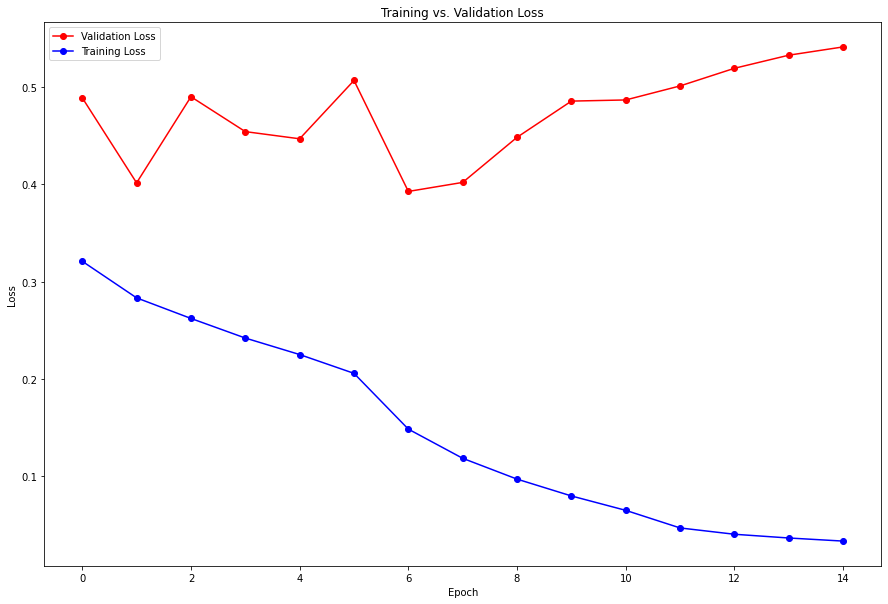

In [17]:
plot_losses(history_8)

### Model 9

In [18]:
# Base Models
base_model_Xc_2 = Xception(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(256, 256, 3)
)

output_layer_Xc_2 = Dense(len(labels), activation='sigmoid')(base_model_Xc_2.output)
model_Xc_2 = Model(base_model_Xc_2.input, output_layer_Xc_2)

for layer in model_Xc_2.layers:
    layer.trainable = True

In [19]:
model_Xc_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [20]:
history_9 = model_Xc_2.fit(
    train_gen[9], 
    validation_data=val_gen[9],
    epochs = 40,
    callbacks = [chkpt[9], early, reduce_lr]
)

Epoch 1/40
250/250 [==============================] - ETA: 0s - loss: 0.1575 - auc_2: 0.0899 - auc_3: 0.6725
Epoch 1: val_loss improved from inf to 0.18751, saving model to ./models/model-9.h5
250/250 [==============================] - 376s 1s/step - loss: 0.1575 - auc_2: 0.0899 - auc_3: 0.6725 - val_loss: 0.1875 - val_auc_2: 0.0971 - val_auc_3: 0.6527 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.1444 - auc_2: 0.1295 - auc_3: 0.7312
Epoch 2: val_loss improved from 0.18751 to 0.14349, saving model to ./models/model-9.h5
250/250 [==============================] - 372s 1s/step - loss: 0.1444 - auc_2: 0.1295 - auc_3: 0.7312 - val_loss: 0.1435 - val_auc_2: 0.1389 - val_auc_3: 0.7370 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.1405 - auc_2: 0.1543 - auc_3: 0.7536
Epoch 3: val_loss did not improve from 0.14349
250/250 [==============================] - 372s 1s/step - loss: 0.1405 - auc_2: 0.1543 - auc_3: 0.7536 -

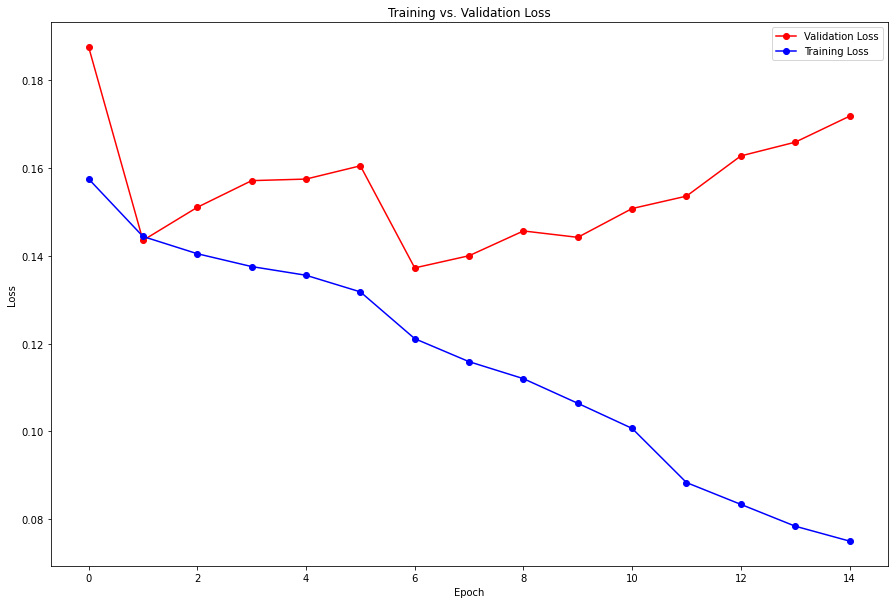

In [21]:
plot_losses(history_9)

### Model 10

In [14]:
# Base Models
base_model_dn169_1 = DenseNet169(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(256, 256, 3)
)

output_layer_dn_1 = Dense(len(labels), activation='sigmoid')(base_model_dn169_1.output)
model_dn_1 = Model(base_model_dn169_1.input, output_layer_dn_1)

for layer in model_dn_1.layers:
    layer.trainable = True

In [15]:
model_dn_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [16]:
history_10 = model_dn_1.fit(
    train_gen[10], 
    validation_data=val_gen[10],
    epochs = 40,
    callbacks = [chkpt[10], early, reduce_lr]
)

Epoch 1/40
282/282 [==============================] - ETA: 0s - loss: 0.3369 - auc: 0.2578 - auc_1: 0.6853
Epoch 1: val_loss improved from inf to 0.44445, saving model to ./models/model-10.h5
282/282 [==============================] - 483s 2s/step - loss: 0.3369 - auc: 0.2578 - auc_1: 0.6853 - val_loss: 0.4445 - val_auc: 0.1997 - val_auc_1: 0.6440 - lr: 0.0010
Epoch 2/40
282/282 [==============================] - ETA: 0s - loss: 0.3098 - auc: 0.3484 - auc_1: 0.7515
Epoch 2: val_loss did not improve from 0.44445
282/282 [==============================] - 468s 2s/step - loss: 0.3098 - auc: 0.3484 - auc_1: 0.7515 - val_loss: 0.4859 - val_auc: 0.2307 - val_auc_1: 0.6903 - lr: 0.0010
Epoch 3/40
282/282 [==============================] - ETA: 0s - loss: 0.2973 - auc: 0.3874 - auc_1: 0.7784
Epoch 3: val_loss improved from 0.44445 to 0.40739, saving model to ./models/model-10.h5
282/282 [==============================] - 465s 2s/step - loss: 0.2973 - auc: 0.3874 - auc_1: 0.7784 - val_loss: 0.4

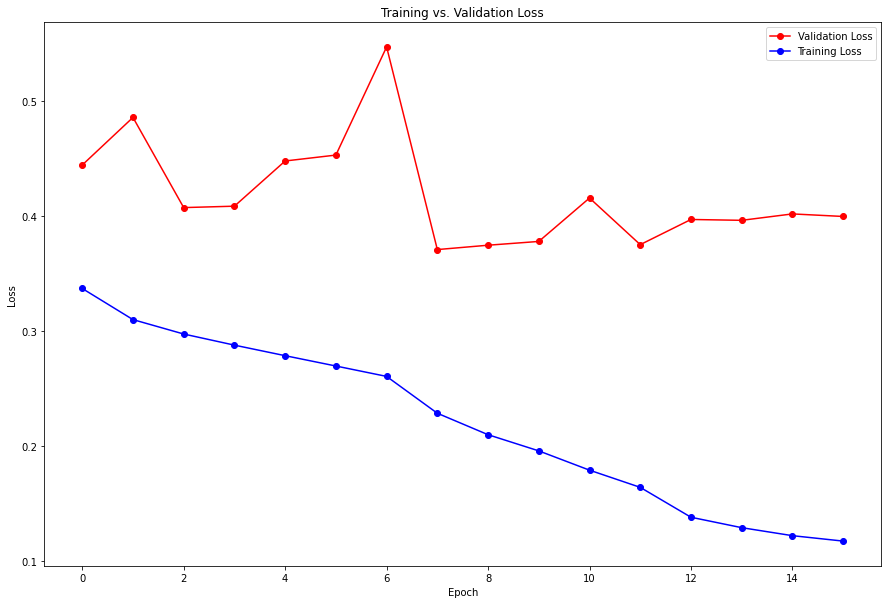

In [17]:
plot_losses(history_10)

### Model 11

In [14]:
# Base Models
base_model_dn169_2 = DenseNet169(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(256, 256, 3)
)

output_layer_dn_2 = Dense(len(labels), activation='sigmoid')(base_model_dn169_2.output)
model_dn_2 = Model(base_model_dn169_2.input, output_layer_dn_2)

for layer in model_dn_2.layers:
    layer.trainable = True

In [15]:
model_dn_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [16]:
history_11 = model_dn_2.fit(
    train_gen[11], 
    validation_data=val_gen[11],
    epochs = 40,
    callbacks = [chkpt[11], early, reduce_lr]
)

Epoch 1/40
250/250 [==============================] - ETA: 0s - loss: 0.1594 - auc: 0.0797 - auc_1: 0.6452
Epoch 1: val_loss improved from inf to 0.33932, saving model to ./models/model-11.h5
250/250 [==============================] - 431s 2s/step - loss: 0.1594 - auc: 0.0797 - auc_1: 0.6452 - val_loss: 0.3393 - val_auc: 0.0626 - val_auc_1: 0.5367 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.1494 - auc: 0.1047 - auc_1: 0.6870
Epoch 2: val_loss improved from 0.33932 to 0.15874, saving model to ./models/model-11.h5
250/250 [==============================] - 419s 2s/step - loss: 0.1494 - auc: 0.1047 - auc_1: 0.6870 - val_loss: 0.1587 - val_auc: 0.1009 - val_auc_1: 0.6839 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.1469 - auc: 0.1157 - auc_1: 0.7074
Epoch 3: val_loss improved from 0.15874 to 0.15282, saving model to ./models/model-11.h5
250/250 [==============================] - 413s 2s/step - loss: 0.1469 - a

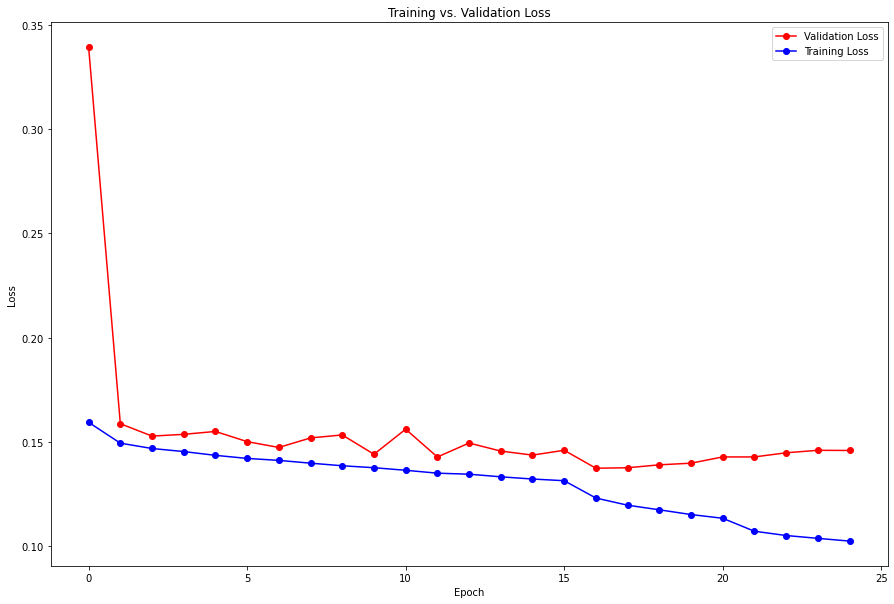

In [17]:
plot_losses(history_11)

### Model 12

In [14]:
# Base Models
base_model_dn169_3 = DenseNet169(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(256, 256, 3)
)

output_layer_dn_3 = Dense(len(labels), activation='sigmoid')(base_model_dn169_3.output)
model_dn_3 = Model(base_model_dn169_3.input, output_layer_dn_3)

for layer in model_dn_3.layers:
    layer.trainable = True

In [15]:
model_dn_3.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg),
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [16]:
history_12 = model_dn_3.fit(
    train_gen[12], 
    validation_data=val_gen[12],
    epochs = 40,
    callbacks = [chkpt[12], early, reduce_lr]
)

Epoch 1/40
250/250 [==============================] - ETA: 0s - loss: 0.7141 - auc: 0.0552 - auc_1: 0.5652
Epoch 1: val_loss improved from inf to 1.49302, saving model to ./models/model-12.h5
250/250 [==============================] - 427s 2s/step - loss: 0.7141 - auc: 0.0552 - auc_1: 0.5652 - val_loss: 1.4930 - val_auc: 0.0494 - val_auc_1: 0.4976 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.7168 - auc: 0.0541 - auc_1: 0.5616
Epoch 2: val_loss did not improve from 1.49302
250/250 [==============================] - 415s 2s/step - loss: 0.7168 - auc: 0.0541 - auc_1: 0.5616 - val_loss: 6.9305 - val_auc: 0.0425 - val_auc_1: 0.4717 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.7237 - auc: 0.0526 - auc_1: 0.5400
Epoch 3: val_loss did not improve from 1.49302
250/250 [==============================] - 416s 2s/step - loss: 0.7237 - auc: 0.0526 - auc_1: 0.5400 - val_loss: 2345.3013 - val_auc: 0.0438 - val_auc_1: 0.49

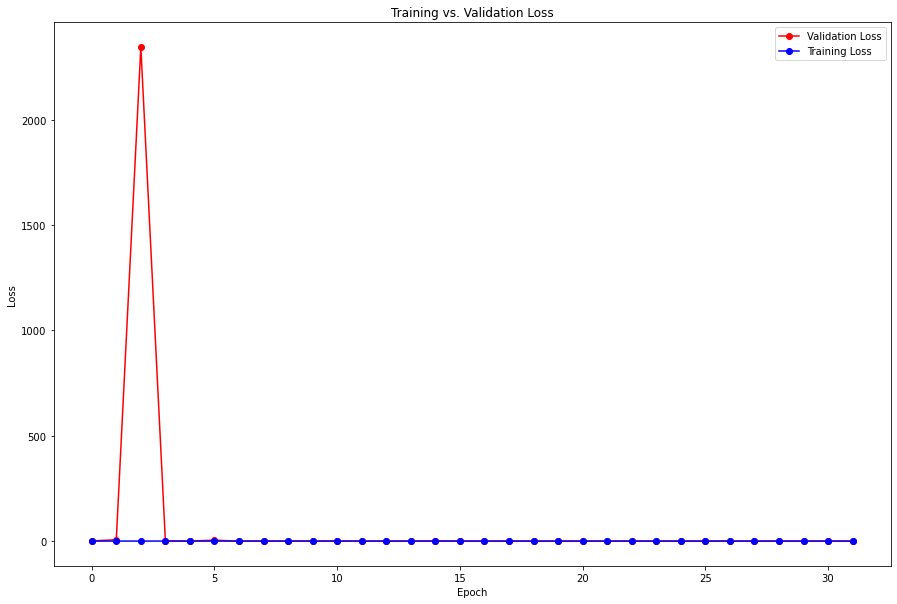

In [17]:
plot_losses(history_12)

## Model Evaluation
---

In [18]:
import csv
from tensorflow.keras.models import load_model

In [19]:
def plot_roc_auc(y_true, y_pred, labels, model_name, file_path, csv_writer, figsize=(15, 10)):
    
    csv_writer.writerow(['label', 'fpr', 'tpr', 'threshold'])
    areas = {}

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])
        areas[lbl] = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = 'Score = %s (AUC: %0.5f)'  % (lbl, areas[lbl]))
        csv_writer.writerows(zip([lbl] * len(fpr), fpr, tpr, thresholds))

    ax.legend()
    ax.set_title('ROC Curves - ' + model_name);
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');
    fig.savefig(file_path)
    plt.close(fig)

    return areas

def plot_precision_recall_auc(y_true, y_pred, labels, model_name, file_path, csv_writer, figsize=(15, 10)):

    csv_writer.writerow(['pr', 'rc', 'threshold'])
    areas = {}

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(y_true[:, i], y_pred[:, i])
        areas[lbl] = auc(rc, pr)
        ax.plot(rc, pr, label = 'Score = %s (AUC: %0.5f)'  % (lbl, areas[lbl]))
        csv_writer.writerows(zip([lbl] * len(pr), pr, rc, thresholds))

    ax.legend()
    ax.set_title('Precision-Recall Curve - ' + model_name);
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');
    fig.savefig(file_path)
    plt.close(fig)

    return areas

In [20]:
for i in np.arange(8, 13):
    model_name = 'model-' + str(i)

    roc_jpg = './results/roc-' + model_name + '.jpg'
    roc_csv = './results/roc-' + model_name + '.csv'
    auroc_csv = './results/auroc-' + model_name + '.csv'
    pr_jpg = './results/pr-' + model_name + '.jpg'
    pr_csv = './results/pr-' + model_name + '.csv'
    aupr_csv= './results/aupr-' + model_name + '.csv'
    
    model = load_model('./models/' + model_name + '.h5', compile=False)

    val_gen[i].reset()
    y_true = val_gen[i].labels
    y_pred = model.predict(val_gen[i], batch_size=64, verbose=True)

    with open(roc_csv, 'w') as f:
        csv_writer = csv.writer(f)
        areas = plot_roc_auc(y_true, y_pred, labels, model_name, roc_jpg, csv_writer, figsize=(15, 10))
    
    with open(auroc_csv, 'w') as f:
        dict_writer = csv.DictWriter(f, fieldnames=labels)
        dict_writer.writeheader()
        dict_writer.writerow(areas)

    with open(pr_csv, 'w') as f:
        csv_writer = csv.writer(f)
        areas = plot_precision_recall_auc(y_true, y_pred, labels, model_name, pr_jpg, csv_writer, figsize=(15, 10))

    with open(aupr_csv, 'w') as f:
        dict_writer = csv.DictWriter(f, fieldnames=labels)
        dict_writer.writeheader()
        dict_writer.writerow(areas)

63/63 [==============================] - 67s 1s/step


For reference, the model summary table from the beginning of the notebook is copied below.

<br>

__MODEL SUMMARY TABLE__
|  | 8 | 9 | 10 | 11 | 12 |
| --- | --- | --- | --- | --- | --- |
| Loss | BCE | BCE | BCE | BCE | Weighted BCE |
| Base Model | Xception | Xception | DenseNet169 | DenseNet169 | DenseNet169 |
| Model Weights | ImageNet | ImageNet | ImageNet | ImageNet | ImageNet |
| Data Sampling | Stratified Sampling | Random | Stratified Sampling | Random | Random |
| Blocks Frozen | Default | Default | Default | Default | Default |
| Pooling Operation | GlobalAvg2D | GlobalAvg2D | GlobalAvg2D | GlobalAvg2D | GlobalAvg2D |

* BCE = Binary Cross Entropy

### Area Under ROC Curve

In [21]:
import os

def highlight_max(s, props=''):
    return np.where(s == np.max(s.values), props, '')

def highlight_min(s, props=''):
    return np.where(s == np.min(s.values), props, '')

results_dir = r'./results/'
csv_files = sorted([x for x in os.listdir(results_dir) if 'csv' in x and 'auroc' in x])

df_list = [pd.read_csv(results_dir + file).assign(File=file) for file in csv_files]

df = pd.concat(df_list, ignore_index=True)
df = df.set_index('File')
df = df.transpose()
df = df[['auroc-model-' + str(x) + '.csv' for x in np.append([1, 3], np.arange(8, 13))]]

df.style.apply(
    highlight_max, props='color:darkgreen;background-color:lightgreen', axis=1
        ).apply(
    highlight_min, props='color:darkred;background-color:salmon', axis=1
        ).set_caption('SUMMARY - Area Under ROC Curve')

File,auroc-model-1.csv,auroc-model-3.csv,auroc-model-8.csv,auroc-model-9.csv,auroc-model-10.csv,auroc-model-11.csv,auroc-model-12.csv
Atelectasis,0.752333,0.647367,0.710342,0.805020,0.683744,0.807237,0.655410
Cardiomegaly,0.731853,0.591033,0.823463,0.876433,0.829669,0.885385,0.660084
Consolidation,0.740801,0.650577,0.720241,0.770228,0.703691,0.774833,0.686224
Edema,0.824379,0.806614,0.938875,0.865731,0.861254,0.861104,0.805362
Effusion,0.839141,0.722434,0.766806,0.862924,0.759072,0.867738,0.709650
Emphysema,0.719543,0.729231,0.951882,0.835920,0.919107,0.833635,0.630113
Fibrosis,0.691720,0.705724,0.893086,0.755066,0.848232,0.759839,0.655661
Hernia,0.540231,0.994824,1.000000,0.815677,0.999694,0.879217,0.881614
Infiltration,0.654226,0.652229,0.673411,0.688193,0.667786,0.680470,0.628106
Mass,0.690715,0.653588,0.856825,0.817245,0.826033,0.828273,0.585042


In [22]:
print('Average AUROC:')
for ind, col in df.iteritems():
    print('%s: %0.6f' % (ind, col.mean()))

Average AUROC:
auroc-model-1.csv: 0.709791
auroc-model-3.csv: 0.693630
auroc-model-8.csv: 0.841146
auroc-model-9.csv: 0.792781
auroc-model-10.csv: 0.803701
auroc-model-11.csv: 0.798406
auroc-model-12.csv: 0.673221


### Area Under PR Curve

In [23]:
csv_files = sorted([x for x in os.listdir(results_dir) if 'csv' in x and 'aupr' in x])

df_list = [pd.read_csv(results_dir + file).assign(File=file) for file in csv_files]

df = pd.concat(df_list, ignore_index=True)
df = df.set_index('File')
df = df.transpose()
df = df[['aupr-model-' + str(x) + '.csv' for x in np.append([1, 3], np.arange(8, 13))]]

df.style.apply(
    highlight_max, props='color:darkgreen;background-color:lightgreen', axis=1
        ).apply(
    highlight_min, props='color:darkred;background-color:salmon', axis=1
        ).set_caption("SUMMARY - Area Under PR Curve")

File,aupr-model-1.csv,aupr-model-3.csv,aupr-model-8.csv,aupr-model-9.csv,aupr-model-10.csv,aupr-model-11.csv,aupr-model-12.csv
Atelectasis,0.241769,0.593453,0.683331,0.352254,0.654967,0.345374,0.151685
Cardiomegaly,0.121912,0.403079,0.744782,0.193811,0.744930,0.263832,0.031206
Consolidation,0.078691,0.505240,0.632587,0.083270,0.585537,0.107521,0.068903
Edema,0.071581,0.086074,0.361517,0.110683,0.156495,0.101858,0.051998
Effusion,0.412831,0.527459,0.615213,0.496465,0.603825,0.504444,0.219052
Emphysema,0.043023,0.071030,0.517317,0.236968,0.401240,0.147693,0.029084
Fibrosis,0.054005,0.043671,0.329403,0.061800,0.117978,0.048489,0.022143
Hernia,0.002525,0.667950,1.000000,0.127865,0.867808,0.021731,0.007826
Infiltration,0.255910,0.358832,0.402864,0.297403,0.378230,0.294157,0.232668
Mass,0.096895,0.146961,0.526295,0.261564,0.383375,0.229640,0.067558


In [24]:
print('Average AUPR:')
for ind, col in df.iteritems():
    print('%s: %0.6f' % (ind, col.mean()))

Average AUPR:
aupr-model-1.csv: 0.118693
aupr-model-3.csv: 0.262950
aupr-model-8.csv: 0.519945
aupr-model-9.csv: 0.197993
aupr-model-10.csv: 0.406334
aupr-model-11.csv: 0.184531
aupr-model-12.csv: 0.074328


# Conclusions

* The larger pre-trained networks (Xception and DenseNet169) performed better than the baseline VGG16 models (model-1 and model-3)

* Weighted loss function did not perform well, even for a larger model.

* Both AUROC and AUPR point to model-8 (Xception trained on a stratified subset of the data) as the best performing model, both with respects to number of green cells (e.g. top performing model for the given label) as well as on average. 

* However, the DenseNet model is not far behind. It is also important to note that the Xception model has 22.9M parameters whereas the DenseNet169 model has 14.3M parameters.

* Based on these results, Xception will be the model used to deploy a prototype deep learning model in the next notebook: scaled-prototype.ipynb (e.g. trained on full set of data instead of subset).

The PR Curve for model-8 and model-10 is shown below.

![image](./results/pr-model-8.jpg)

For reference, the ROC curve for model-8 and model-10 are also shown below.

![image](./results/roc-model-8.jpg)